In [1]:
import networkx as nx
import math
import numpy as np
import random
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
import sys
import contextlib
import itertools
from math import comb
from numpy import linalg as LA
import math
from numpy.linalg import matrix_power
import matplotlib.pyplot as plt
from math import factorial as f
import networkx as nx
import itertools
import scipy


# function to compute the fixation probability of the Moran process for given number of nodes and a fitness value
def theoretic_fixation_moran(nodes,fitness):
    if fitness==1:
        return 1/(nodes)
    else:
        k=(1-1/fitness)/(1-1/(pow(fitness,nodes)))
        return k

# function to compute the fixation probability of the star graph    
def star_fixation(n,r):
    if r==1:
        return 1/(n)
    else:
        k=(1-(1/(r**2)))/(1-(1/(r**(2*n))))
        return k
    

def nCr(n,r):
    return f(n) // f(r) // f(n-r)

# function to enumerate all non isomorphic networks on a given number of nodes
# source:https://stackoverflow.com/questions/59643724/given-a-node-set-enumerate-graphs-on-it
def get_all_graphs(n):
    rows = sorted(itertools.product(range(2), repeat=nCr(n,2)), key= lambda x: sum(x))

    indices = [sum(range(n-1, n-i-1, -1)) for i in range(n)] + [sum(range(n))]

    graphs = [{node: [j+node+1 for j, edge in enumerate(row[indices[node] : indices[node+1]]) if edge == 1] for node in range(n)} for row in rows]
    return[nx.from_dict_of_lists(x) for x in graphs]
    

    
def iso_graph(graph_list):
    iso_list = []
    for l in graph_list:
        if nx.is_connected(l):
            iso_list.append(l)
            
    con_iso_list=[]
    con_iso_list.append(iso_list[0])
    
    for j in iso_list:
        for k in range(len(con_iso_list)):
            if nx.is_isomorphic(con_iso_list[k],j)==True:
                    break
            if k==len(con_iso_list)-1:
                con_iso_list.append(j)
    return con_iso_list


# function to create the transition matrix of a network, for a given fitness values
def T_Mat(G,r):

    if type(G) == nx.classes.graph.Graph :
        n=nx.number_of_nodes(G)
        A=nx.adjacency_matrix(G)
        
        #T is the transition matrix
    elif type(G) == np.ndarray or type(G) == scipy.sparse.csr.csr_matrix or type(G) ==np.matrix :
        A=G
        n=np.shape(A)[0]
      
    
    T=np.zeros((2**(n),2**(n)),dtype='float')
    
    #one-one correspondence bit strings 
    #zero denotes resident in the corresponding vertex in the graph and one the mutant
    lst = list(itertools.product([0, 1], repeat=n))
    bit_strings = np.array(lst)
    
    
    #setting the entries of T, iteratively
    for i in range(2**(n)):
        #finding the entries of bit_strings which correspond to the states with exactly one mutant
        #k is the number of mutants in state i
        k= np.count_nonzero(bit_strings[i]!=0)
        
        for j in range(2**(n)):
            
            #Checking that the corresponding bit strings i and j only differ in one entry
            if LA.norm(bit_strings[i]-bit_strings[j])==1 :
                
                #Checking whether theres an increase or decrease in number of mutants 
                arr=bit_strings[j]-bit_strings[i]
                #new_arr_no_0 contains a single entry, either -1 or 1
                new_arr_no_0 = arr[arr!=0]
                #new_node is the difference node between i and j
                new_node= np.nonzero(arr)[0][0]
                
                #if i==1 and j==0:
                    #print("The sign is",np.sign(new_arr_no_0[0]))
                
                #if there is a gain in mutant number
                if np.sign(new_arr_no_0[0])==1:
                    #s is an array that contains the non-zero indices (mutants)
                    s= np.nonzero(bit_strings[i])[0]
                    
                    for l in s:
                        T[i,j] += A[l,new_node]/(np.sum(A,axis=1)[l])
                    
                    T[i,j]=(r/(r*k+n-k))*T[i,j]
                
                #if there is a drop in mutant number    
                elif np.sign(new_arr_no_0[0])==-1:
                    #t is an array that contains the zero indices (residents)
                    t= np.where(bit_strings[i] == 0)[0]
                    
                    for l in t:
                        T[i,j] += A[l,new_node]/((np.sum(A,axis=1)[l]))     
                    
                    T[i,j]=(1/(r*k+n-k))*T[i,j]
                        
                
            if LA.norm(bit_strings[i])==0 :
                T[i,i]=1
                T[i,j]=0
                    
       
    for i in range(1,2**(n)):
        T[i,i]= 1- np.sum(T,axis=1)[i]
        
    return T

# function that returns fixation probability when a transition matrix is entered
def matrix_solver(M):
    Q=M[1:-1,1:-1]
    p2=M[1:-1,-1:]
    n = np.shape(Q)[0]
    #m is the number of nodes in the graph
    m = int(math.log2(n+2))
    fixn_arr = np.linalg.solve(Q-np.identity(n), -p2)
    fixn=0
    c=[]
    
    lst = list(itertools.product([0, 1], repeat=m))
    bit_strings = np.array(lst)
    
    for i in range(2**m-1):
        if np.count_nonzero(bit_strings[i] == 1)==1 :
            c.append(i)
    #print(c)
    
    for i in c:
        fixn += fixn_arr[i-1]
    return fixn[0]/m


def switch_matrix_solver(M,N,t):
    if np.shape(M) != np.shape(N):
        print("Matrices have different dimensions!")
        return 0
    
    T= np.matmul(matrix_power(M, t),matrix_power(N, t))
    Q=T[1:-1,1:-1]
    p2=T[1:-1,-1:]
    n = np.shape(Q)[0]
    #m is the number of nodes in the graph
    m = int(math.log2(n+2))
    fixn_arr = np.linalg.solve(Q-np.identity(n), -p2)
    fixn=0
    c=[]
    
    lst = list(itertools.product([0, 1], repeat=m))
    bit_strings = np.array(lst)
    
    for i in range(2**m-1):
        if np.count_nonzero(bit_strings[i] == 1)==1 :
            c.append(i)
    #print(c)
    
    for i in c:
        fixn += fixn_arr[i-1]
    return fixn[0]/m
    
    
    
def sum_graph(graph1,graph2):
    graph3 = nx.Graph()
    graph3.add_nodes_from(graph1.nodes())
    elist=list(graph1.edges())+list(graph2.edges())
    graph3.add_edges_from(elist)
    #adding weight
    for i in elist:
        graph3.edges[i]['weight'] = elist.count(i)
    return graph3        

graph_enum_6 = iso_graph(get_all_graphs(6))



def T_weightMat(G,r):
    if type(G) == nx.classes.graph.Graph:
        n=nx.number_of_nodes(G)
        A=nx.adjacency_matrix(G)
        #A=nx.adjacency_matrix(G, weight='weight')
        #T is the transition matrix
    elif type(G) == np.ndarray:
        A=G
        n=np.shape(A)[0]
    
    T=np.zeros((2**(n),2**(n)),dtype='float')
    
    #one-one correspondence bit strings 
    #zero denotes resident in the corresponding vertex in the graph and one the mutant
    lst = list(itertools.product([0, 1], repeat=n))
    bit_strings = np.array(lst)
    
    
    #setting the entries of T, iteratively
    for i in range(2**(n)):
        #finding the entries of bit_strings which correspond to the states with exactly one mutant
        #k is the number of mutants in state i
        k= np.count_nonzero(bit_strings[i]!=0)
        
        for j in range(2**(n)):
            
            #Checking that the corresponding bit strings i and j only differ in one entry
            if LA.norm(bit_strings[i]-bit_strings[j])==1 :
                
                #Checking whether theres an increase or decrease in number of mutants 
                arr=bit_strings[j]-bit_strings[i]
                #new_arr_no_0 contains a single entry, either -1 or 1
                new_arr_no_0 = arr[arr!=0]
                #new_node is the difference node between i and j
                new_node= np.nonzero(arr)[0][0]
                
                #if i==1 and j==0:
                    #print("The sign is",np.sign(new_arr_no_0[0]))
                
                #if there is a gain in mutant number
                if np.sign(new_arr_no_0[0])==1:
                    #s is an array that contains the non-zero indices (mutants)
                    s= np.nonzero(bit_strings[i])[0]
                    
                    for l in s:
                        T[i,j] += A[l,new_node]/(G.degree(l,weight='weight'))
                    
                    T[i,j]=(r/(r*k+n-k))*T[i,j]
                
                #if there is a drop in mutant number    
                elif np.sign(new_arr_no_0[0])==-1:
                    #t is an array that contains the zero indices (residents)
                    t= np.where(bit_strings[i] == 0)[0]
                    
                    for l in t:
                        T[i,j] += A[l,new_node]/(G.degree(l,weight='weight'))     
                    
                    T[i,j]=(1/(r*k+n-k))*T[i,j]
                        
                
            if LA.norm(bit_strings[i])==0 :
                T[i,i]=1
                T[i,j]=0
                    
       
    for i in range(1,2**(n)):
        T[i,i]= 1- np.sum(T,axis=1)[i]
        
    return T



def permute(G):
    A=nx.adjacency_matrix(G).todense()
    P=np.random.permutation(np.identity(G.number_of_nodes()))
    T= np.matmul(np.matmul(P,A),np.transpose(P))
    return T

def star_anfixn(N,r):
    fixn=0
    a=N-1
    if r==1:
        fixn = 1/N
        return fixn
    else:
        num = 1-(((N-1)*(r+a))/(N*(r*(r*a+1))))-((1/N)*((r*a+1)/((r*(r+a)))))
        den = 1-(r**(-N))*(((r+a)/(r*a+1))**(N-2))
        return num/den



In [4]:
[star_anfixn(6,i/10) for i in range(1,20)]

[2.0820758866012967e-07,
 1.4220595041407789e-05,
 0.00018590305893478531,
 0.0011637817213533393,
 0.004704181647184334,
 0.01405057435818364,
 0.033327741603651866,
 0.065672649547654,
 0.11121010671860473,
 0.16666666666666666,
 0.2269681743728555,
 0.2873307016101632,
 0.3444414458422505,
 0.39657322762451785,
 0.44316877687298284,
 0.4843594690062707,
 0.5206080148129372,
 0.5524927873753431,
 0.5805949531434575]

## Transition matrices for special graphs

##### Star+Complete Matrix ($2n x 2n$) 

In [16]:
def star_Tmat(n,r):#n nodes
    #Check if G is indeed a star graph
    T=np.zeros((2*(n),2*(n)),dtype='float')
    
    bit_list = []
    for i in range(2):
        for j in range(n):
            bit_list.append([i,j])
    
    string_list = np.array(bit_list)
    
    for i in range(2*(n)):
        for j in range(2*(n)):
            a=string_list[i][1]
            if LA.norm(string_list[i]-string_list[j])==1:
                if string_list[i][0]==0:
                    
                    if string_list[j][0]==1:
                        T[i,j]= r*(a)/(r*a+(n-a))
                    else:
                        if string_list[i][1]-string_list[j][1]==1:
                            T[i,j]= (a)/((r*a+(n-a))*(n-1))
                            
                            
                elif string_list[i][0]==1:
                    
                    if string_list[j][0]==0:
                        T[i,j]= (n-a-1)/(r*(a+1)+(n-a-1))
                    else:
                        if string_list[j][1]-string_list[i][1]==1:
                            T[i,j]= r*(n-a-1)/((r*(a+1)+(n-a-1))*(n-1))
                            
                            
                            
    for i in range(1,2*(n)):
        T[i,i]= 1- np.sum(T,axis=1)[i]
        
    T[0,0]=1

    
    return T


def complete_Tmat(n,r):#n nodes
    T=np.zeros((2*(n),2*(n)),dtype='float')
    
    bit_list = []
    for i in range(2):
        for j in range(n):
            bit_list.append([i,j])
    
    string_list = np.array(bit_list)
    
    for i in range(1,2*(n)):
        for j in range(2*(n)):
            a=string_list[i][1]
            if LA.norm(string_list[i]-string_list[j])==1:
                if string_list[i][0]==0:
                    
                    if string_list[j][0]==1:
                        T[i,j]= (r*(a)/(r*a+(n-a)))*(1/(n-1))
                    elif string_list[i][1]-string_list[j][1]==1:                
                        T[i,j]= ((n-a)/(r*a+(n-a)))*(a/(n-1))
                    elif string_list[j][1]-string_list[i][1]==1:                
                        T[i,j]= ((r*a)/(r*a+(n-a)))*((n-a-1)/(n-1))
                    
                            
                            
                elif string_list[i][0]==1:
                    
                    if string_list[j][0]==0:
                        T[i,j]= ((n-a-1)/(r*(a+1)+(n-a-1)))*(1/(n-1))
                    elif string_list[j][1]-string_list[i][1]==1:
                        T[i,j]= (r*(a+1)*(n-a-1))/((r*(a+1)+(n-a-1))*(n-1))             
                    elif string_list[i][1]-string_list[j][1]==1:                
                        T[i,j]= ((a)*(n-a-1))/((r*(a+1)+(n-a-1))*(n-1)) 
                            
                            
                            
    for i in range(1,2*(n)):
        T[i,i]= 1- np.sum(T,axis=1)[i]
        
    T[0,0]=1
    T[-1,-1]=1
    
    return T
    
    
               
        
                    
                    
    
    

#### Star+Regular aggregate graph

In [17]:
def star_complete_agg_Tmat(n,r):#n nodes
    T=np.zeros((2*(n),2*(n)),dtype='float')
    
    bit_list = []
    for i in range(2):
        for j in range(n):
            bit_list.append([i,j])
    
    string_list = np.array(bit_list)
    
    for i in range(1,2*(n)):
        for j in range(2*(n)):
            a=string_list[i][1]
            if LA.norm(string_list[i]-string_list[j])==1:
                if string_list[i][0]==0:
                    k1=(r*a+(n-a))
                    
                    if string_list[j][0]==1:
                        T[i,j]= (r*(a)/(k1))*(2/(n))
                    elif string_list[i][1]-string_list[j][1]==1:                
                        T[i,j]= ((n-a-1)/(k1))*(a/n)+(1/k1)*(2*a/(2*(n-1)))
                    elif string_list[j][1]-string_list[i][1]==1:                
                        T[i,j]= ((r*a)/(k1))*((n-a-1)/(n))
                    
                            
                            
                elif string_list[i][0]==1:
                    k2=r*(a+1)+(n-a-1)
                    
                    if string_list[j][0]==0:
                        T[i,j]= ((n-a-1)/(k2))*(2/(n))
                    elif string_list[j][1]-string_list[i][1]==1:
                        T[i,j]= ((r*a)/(k2))*((n-a-1)/n)+(r/k2)*(2*(n-a-1)/(2*(n-1)))           
                    elif string_list[i][1]-string_list[j][1]==1:                
                        T[i,j]= ((n-a-1)/(k2))*(a/n) 
                            
                            
                            
    for i in range(1,2*(n)):
        T[i,i]= 1- np.sum(T,axis=1)[i]
        
    T[0,0]=1
    T[-1,-1]=1
    
    return T
    
    
                    
           

###### Star+Regular Matrix Solver

In [18]:
def matrix_2n_solver(M):
    Q=M[1:-1,1:-1]
    p2=M[1:-1,-1:]
    n = np.shape(Q)[0]
    #m is the number of nodes in the graph
    m = (n+2)/2
    fixn_arr = np.linalg.solve(Q-np.identity(n), -p2)
    fixn=0
    

    fixn = (fixn_arr[0]*((m-1)/(m))) + (fixn_arr[int(m-1)]*((1)/(m)))
    #return fixn_arr
    return [fixn[0],m,n][0]#the three entries are just for debugging


def switch_matrix_2n_solver(M,N,t):
    if np.shape(M) != np.shape(N):
        print("Matrices have different dimensions!")
        return 0
    
    T= np.matmul(matrix_power(M, t),matrix_power(N, t))
    Q=T[1:-1,1:-1]
    p2=T[1:-1,-1:]
    n = np.shape(Q)[0]
    #m is the number of nodes in the graph
    m = (n+2)/2
    fixn_arr = np.linalg.solve(Q-np.identity(n), -p2)
    fixn=0

    fixn = (fixn_arr[0]*((m-1)/(m))) + (fixn_arr[int(m-1)]*((1)/(m)))
    #return fixn_arr
    return [fixn[0],m,n][0]#the three entries are just for debugging

def star_complete_solver(n,r):
    M=star_complete_agg_Tmat(n,r)
    Q=M[1:-1,1:-1]
    p2=M[1:-1,-1:]
    n = np.shape(Q)[0]
    #m is the number of nodes in the graph
    m = (n+2)/2
    fixn_arr = np.linalg.solve(Q-np.identity(n), -p2)
    fixn=0
    fixn = (fixn_arr[0]*((m-1)/(m))) + (fixn_arr[int(m-1)]*((1)/(m)))
    return fixn[0]

##### Star+Bipartite Matrix ($2(m)(n+1) x 2(m)(n+1)$) 

In [19]:

def bipartite_mn_Tmat(m,n,r):#n nodes
    #Check if G is indeed a star graph
    T=np.zeros(((m+1)*(n+1),(m+1)*(n+1)),dtype='float')
    N=m+n
    bit_list = []
    for i in range(m+1):
        for j in range(n+1):
            bit_list.append([i,j])
            
              
    string_list = np.array(bit_list)
    
    for i in range(1,(m+1)*(n+1)):
        for j in range((m+1)*(n+1)):
            
            a= string_list[i][0] #i
            b= string_list[i][1] #j
            c= string_list[j][0] 
            d= string_list[j][1]
            
            if LA.norm(string_list[i]-string_list[j])==1:
            

            
                if a==c:
                    if d-b==1:
                        T[i,j]=((r*a)*(n-b))/((r*(a+b)+(N-(a+b)))*n)
                    elif b-d==1:
                        T[i,j]=((m-a)*(b))/((r*(a+b)+(N-(a+b)))*n)
                
                elif b==d:
                    if c-a==1:
                        T[i,j]=((r*b)*(n-a))/((r*(a+b)+(N-(a+b)))*m)
                    elif a-c==1:
                        T[i,j]=((n-b)*(a))/((r*(a+b)+(N-(a+b)))*m)

       
                            
                            
    for i in range(1,(m+1)*(n+1)):
        T[i,i]= 1- np.sum(T,axis=1)[i]
        
    T[0,0]=1
    T[-1,-1]=1
    
    return T

#########################################################################

def bipartite_Tmat(m,n,r):
    N=m+n
    bit_list = []
    for i in range(2):
        for j in range(m):
            for k in range(n+1):
                bit_list.append([i,j,k])   
            
              
    string_list = np.array(bit_list)
    T=np.zeros((2*(m)*(n+1),2*(m)*(n+1)),dtype='float')
    
    for i in range(1,2*(m)*(n+1)):
        for j in range(2*(m)*(n+1)):
            a=string_list[i][1]
            b=string_list[i][2]
            k1=(a+b)*r+(N-a-b)
            k2=(a+b+1)*r+(N-1-a-b)
            if LA.norm(string_list[i]-string_list[j])==1:
                if string_list[i][0]==0:
                    if string_list[j][0]==1:
                        T[i,j]=((b*r)/(k1))*(1/m)
                    elif string_list[i][1]-string_list[j][1]==1:
                        T[i,j]=((n-b)/(k1))*(a/m)
                    elif string_list[j][1]-string_list[i][1]==1:
                        T[i,j]=((b*r)/(k1))*((m-a-1)/m)
                    elif string_list[i][2]-string_list[j][2]==1:
                        T[i,j]=((m-a)/(k1))*(b/n)
                    elif string_list[j][2]-string_list[i][2]==1:
                        T[i,j]= ((a*r)/(k1))*((n-b)/n)
                    else:
                        print(string_list[i],string_list[j])
                        
                    
                    
              
                    
                if string_list[i][0]==1:
                    if string_list[j][0]==0:
                        T[i,j]=((n-b)/k2)*(1/m)
                    elif string_list[i][1]-string_list[j][1]==1:
                        T[i,j]=((n-b)/k2)*(a/m)
                    elif string_list[j][1]-string_list[i][1]==1:
                        T[i,j]=((r*b)/k2)*((m-a-1)/m)
                    elif string_list[i][2]-string_list[j][2]==1:
                        T[i,j]=((m-1-a)/(k2))*(b/n)
                    elif string_list[j][2]-string_list[i][2]==1:
                        T[i,j]=(((a+1)*r)/k2)*((n-b)/n)
                    else:
                        print(string_list[i],string_list[j])
                        
    
    for i in range(1,2*(m)*(n+1)-1):
        T[i,i]= 1- np.sum(T,axis=1)[i]
        
    T[0,0]=1
    T[-1,-1]=1
    return T

#########################################################################

def star_2mn_Tmat(l,n,r):#m+n nodes
    #Check if G is indeed a star graph
    
    N=l+n
    m=l-1
    bit_list = []
    for i in range(2):
        for j in range(m+1):
            for k in range(n+1):
                bit_list.append([i,j,k])   
            
              
    string_list = np.array(bit_list)
    T=np.zeros((2*(m+1)*(n+1),2*(m+1)*(n+1)),dtype='float')
    
    for i in range(2*(m+1)*(n+1)):
        for j in range(2*(m+1)*(n+1)):
            a=string_list[i][1]
            b=string_list[i][2]
            if LA.norm(string_list[i]-string_list[j])==1:
                if string_list[i][0]==0:
                    if string_list[j][0]==1:
                        T[i,j]=((a+b)*r)/((a+b)*r+(N-(a+b))) #*1
                    elif string_list[i][1]-string_list[j][1]==1:
                        T[i,j]=(1/(((a+b)*r)+(N-a-b)))*((a)/(N-1))
                    elif string_list[i][2]-string_list[j][2]==1:
                        T[i,j]=(1/(((a+b)*r)+(N-a-b)))*((b)/(N-1))
                        
                        
                    
                    
                if string_list[i][0]==1:
                    
                    if string_list[j][0]==0:
                        T[i,j]=(N-(a+b+1))/((a+b+1)*r+(N-(a+b+1)))
                    elif string_list[j][1]-string_list[i][1]==1:
                        T[i,j]=(r/(((a+b+1)*r)+(N-a-b-1)))*((m-a)/(m+n))
                    elif string_list[j][2]-string_list[i][2]==1:
                        T[i,j]=((r)/((a+b+1)*r+(N-(a+b+1))))*((n-b)/(m+n))
                    


       
                            
                            
    for i in range(1,2*(m+1)*(n+1)):
        T[i,i]= 1- np.sum(T,axis=1)[i]
        
    T[0,0]=1
    T[-1,-1]=1
    
    return T





In [20]:
def star_bipartite_sum_Tmat(m,n,r):
    N=m+n
    bit_list = []
    for i in range(2):
        for j in range(m):
            for k in range(n+1):
                bit_list.append([i,j,k])   
            
              
    string_list = np.array(bit_list)
    T=np.zeros((2*(m)*(n+1),2*(m)*(n+1)),dtype='float')
    
    for i in range(1,2*(m)*(n+1)):
        for j in range(2*(m)*(n+1)):
            a=string_list[i][1]
            b=string_list[i][2]
            k1=(a+b)*r+(N-a-b)
            k2=(a+b+1)*r+(N-1-a-b)
            if LA.norm(string_list[i]-string_list[j])==1:
                if string_list[i][0]==0:
                    if string_list[j][0]==1:
                        T[i,j]=((b*r)/(k1))*(2/(m+1))+((a*r)/(k1))*(1/(n+1))
                    elif string_list[i][1]-string_list[j][1]==1:
                        T[i,j]=((n-b)/(k1))*(a/(m+1))+(1/k1)*(a/(m-1+2*n))
                    elif string_list[j][1]-string_list[i][1]==1:
                        T[i,j]=((b*r)/(k1))*((m-a-1)/(m+1))
                    elif string_list[i][2]-string_list[j][2]==1:
                        T[i,j]=((m-a-1)/(k1))*(b/(n+1))+(1/k1)*(2*b/(m-1+2*n))
                    elif string_list[j][2]-string_list[i][2]==1:
                        T[i,j]= ((a*r)/(k1))*((n-b)/(n+1))
                    else:
                        print(string_list[i],string_list[j])
                                            
                    
              
                    
                if string_list[i][0]==1:
                    if string_list[j][0]==0:
                        T[i,j]=((m-a-1)/(k2))*(1/(n+1))+((n-b)/(k2))*(2/(m+1))
                    elif string_list[i][1]-string_list[j][1]==1:
                        T[i,j]=((n-b)/k2)*(a/(m+1))
                    elif string_list[j][1]-string_list[i][1]==1:
                        T[i,j]=((r*b)/k2)*((m-a-1)/(m+1))+((r/k2)*((m-a-1))/(m-1+2*n))
                    elif string_list[i][2]-string_list[j][2]==1:
                        T[i,j]=((m-1-a)/(k2))*(b/(n+1))
                    elif string_list[j][2]-string_list[i][2]==1:
                        T[i,j]=(((a)*r)/k2)*((n-b)/(n+1))+(r/k2)*(2*(n-b))/(m-1+2*n)
                    else:
                        print(string_list[i],string_list[j])
                        
                        

    
    for i in range(1,2*(m)*(n+1)-1):
        T[i,i]= 1- np.sum(T,axis=1)[i]
        
    T[0,0]=1
    T[-1,-1]=1
                        
    return T

#### Star+Bipartite solvers

In [6]:
def matrix_bp2mn_solver(r,a,b):
    M=bipartite_Tmat(a,b,r)
    Q=M[1:-1,1:-1]
    p2=M[1:-1,-1:]
    n = np.shape(Q)[0]
    
    #m is the number of nodes in the graph
    m = a+b
    fixn_arr = np.linalg.solve(Q-np.identity(n), -p2)
    fixn=0
    
    #print(c)
    
    fixn = fixn_arr[0]*(b/m)+fixn_arr[b]*((a-1)/m)+(fixn_arr[a*(b+1)-1])*(1/m)
    return fixn[0]
    #print(fixn[0])
    #return fixn_arr


def matrix_star2mn_solver(r,a,b):
    M=star_2mn_Tmat(a,b,r)
    Q=M[1:-1,1:-1]
    p2=M[1:-1,-1:]
    n = np.shape(Q)[0]
    
    #m is the number of nodes in the graph
    m = a+b
    fixn_arr = np.linalg.solve(Q-np.identity(n), -p2)
    fixn=0
    
    #print(c)
    
    fixn = fixn_arr[0]*(b/m)+fixn_arr[b]*((a-1)/m)+(fixn_arr[a*(b+1)-1])*(1/m)
    return fixn[0]
    #print(fixn[0])
    #return fixn_arr

def switch_matrix_2mn_solver(a,b,r,s,t):
    #a,b are shape of graph
    #r is fitness
    #s is 0 or 1, if zero, its star+bip, if one, bip+star
    M=star_2mn_Tmat(a,b,r)
    N=bipartite_Tmat(a,b,r)
    if np.shape(M) != np.shape(N):
        print("Matrices have different dimensions!")
        return 0
    if s==0:
        T= np.matmul(matrix_power(M, t),matrix_power(N, t))
    elif s==1:
        T= np.matmul(matrix_power(N, t),matrix_power(M, t))
    

    Q=T[1:-1,1:-1]
    p2=T[1:-1,-1:]
    n = np.shape(Q)[0]
    #m is the number of nodes in the graph
    m = a+b
    fixn_arr = np.linalg.solve(Q-np.identity(n), -p2)
    fixn=0
    
    fixn = fixn_arr[0]*(b/m)+fixn_arr[b]*((a-1)/m)+(fixn_arr[a*(b+1)-1])*(1/m)
    return fixn[0]
    #fixn = (fixn_arr[0]*((m-1)/(m))) + (fixn_arr[int(m-1)]*((1)/(m)))
    #return fixn_arr
    #return [fixn[0],m,n][0]#the three entries are just for debugging
    
    
def matrix_starbp2mn_solver(r,a,b):
    M=star_bipartite_sum_Tmat(a,b,r)
    Q=M[1:-1,1:-1]
    p2=M[1:-1,-1:]
    n = np.shape(Q)[0]
    
    #m is the number of nodes in the graph
    m = a+b
    fixn_arr = np.linalg.solve(Q-np.identity(n), -p2)
    fixn=0
    
    #print(c)
    
    fixn = fixn_arr[0]*(b/m)+fixn_arr[b]*((a-1)/m)+(fixn_arr[a*(b+1)-1])*(1/m)
    return fixn[0]
    

def matrix_2mn_solver(M):
    Q=M[1:-1,1:-1]
    p2=M[1:-1,-1:]
    n = np.shape(Q)[0]
    
    #m is the number of nodes in the graph
    m = a+b
    fixn_arr = np.linalg.solve(Q-np.identity(n), -p2)
    fixn=0
    
    #print(c)
    
    fixn = fixn_arr[0]*(b/m)+fixn_arr[b]*((a-1)/m)+(fixn_arr[a*(b+1)-1])*(1/m)
    return fixn[0]
    #print(fixn[0])
    #return fixn_arr
    


## Random initialization time

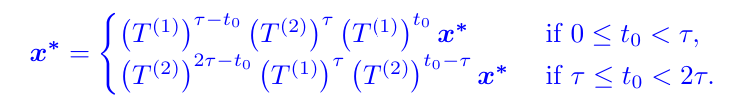

### Arbitrary graphs

In [10]:
## code for generating fixation probability of random initialization
def random_switching_fixn(G1,G2,r,tau):

    T1=T_Mat(G1,r)
    T2=T_Mat(G2,r)
    if np.shape(T1) != np.shape(T2):
        print("Matrices have different dimensions!")
        return 0
    fixation_list=[]
    c=0
    for t0 in range(2*tau):
        if t0<tau:
            T= np.matmul(np.matmul(matrix_power(T1, tau-t0),matrix_power(T2, tau)),matrix_power(T1, t0))
        elif t0>=tau:
            T= np.matmul(np.matmul(matrix_power(T2, 2*tau-t0),matrix_power(T1, tau)),matrix_power(T2, t0-tau))
        fixation_list.append(matrix_solver(T))
        
    for i in range(len(fixation_list)):
        c+=fixation_list[i]
    return c/len(fixation_list)

### Special graphs

##### Star+Complete

In [8]:
## code for generating fixation probability of random initialization
def random_switching_fixn_star_comp(n,r,tau):

    T1=star_Tmat(n,r)
    T2=complete_Tmat(n,r)
    if np.shape(T1) != np.shape(T2):
        print("Matrices have different dimensions!")
        return 0
    fixation_list=[]
    c=0
    for t0 in range(2*tau):
        if t0<tau:
            T= np.matmul(np.matmul(matrix_power(T1, tau-t0),matrix_power(T2, tau)),matrix_power(T1, t0))
        elif t0>=tau:
            T= np.matmul(np.matmul(matrix_power(T2, 2*tau-t0),matrix_power(T1, tau)),matrix_power(T2, t0-tau))
        fixation_list.append(matrix_2n_solver(T))
        
    for i in range(len(fixation_list)):
        c+=fixation_list[i]
    return c/len(fixation_list)

##### Star+Bipartite

In [4]:
## code for generating fixation probability of random initialization
def random_switching_fixn_star_bip(a,b,r,tau):

    T1=star_2mn_Tmat(a,b,r)
    T2=bipartite_Tmat(a,b,r)
    if np.shape(T1) != np.shape(T2):
        print("Matrices have different dimensions!")
        return 0
    fixation_list=[]
    c=0
    for t0 in range(2*tau):
        if t0<tau:
            T= np.matmul(np.matmul(matrix_power(T1, tau-t0),matrix_power(T2, tau)),matrix_power(T1, t0))
        elif t0>=tau:
            T= np.matmul(np.matmul(matrix_power(T2, 2*tau-t0),matrix_power(T1, tau)),matrix_power(T2, t0-tau))
        fixation_list.append(matrix_2mn_solver(T))
        
    for i in range(len(fixation_list)):
        c+=fixation_list[i]
    return c/len(fixation_list)

In [61]:
import time
start_time = time.time()

a,b,r,tau=5,10,0.852,10

print(random_switching_fixn_star_bip(a,b,r,tau)-theoretic_fixation_moran(a+b,r))
end_time = time.time()
print("it took this long to run: {}".format(end_time-start_time))


-0.004066921568405487
it took this long to run: 0.762298583984375


In [9]:
def matrix_2mn_solver(M,a,b):
    Q=M[1:-1,1:-1]
    p2=M[1:-1,-1:]
    n = np.shape(Q)[0]
    
    #m is the number of nodes in the graph
    m = a+b
    fixn_arr = np.linalg.solve(Q-np.identity(n), -p2)
    fixn=0
    
    #print(c)
    
    fixn = fixn_arr[0]*(b/m)+fixn_arr[b]*((a-1)/m)+(fixn_arr[a*(b+1)-1])*(1/m)
    return fixn[0]

## code for generating fixation probability of random initialization
def random_switching_fixn_star_bip(a,b,r,tau):

    T1=star_2mn_Tmat(a,b,r)
    T2=bipartite_Tmat(a,b,r)
    if np.shape(T1) != np.shape(T2):
        print("Matrices have different dimensions!")
        return 0
    fixation_list=[]
    c=0
    for t0 in range(2*tau):
        if t0<tau:
            T= np.matmul(np.matmul(matrix_power(T1, tau-t0),matrix_power(T2, tau)),matrix_power(T1, t0))
        elif t0>=tau:
            T= np.matmul(np.matmul(matrix_power(T2, 2*tau-t0),matrix_power(T1, tau)),matrix_power(T2, t0-tau))
        fixation_list.append(matrix_2mn_solver(T,a,b))
        
    for i in range(len(fixation_list)):
        c+=fixation_list[i]
    return c/len(fixation_list)

### Stochastic

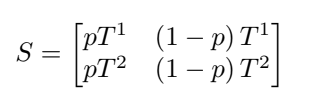

In [45]:
def S_Mat(G1,G2,r,p):##stochastic matrix 
    n=G1.number_of_nodes()
    S=np.zeros((2*2**(n),2*2**(n)),dtype='float')
    T1 = T_Mat(G1,r)
    T2 = T_Mat(G2,r)
    
    S=np.block([
        [p*T1,(1-p)*T1],
            [p*T2,(1-p)*T2]
    ])     

            
    return S


def matrix_solver_stochastic(M,n):
    #print(0)
    Q11=M[1:2**(n)-1,1:2**(n)-1]
    Q21=M[2**(n)+1:-1,1:2**(n)-1]
    Q12=M[1:2**(n)-1,2**(n)+1:-1]
    Q22=M[2**(n)+1:-1,2**(n)+1:-1]
    Q = np.block([[Q11, Q12], [Q21, Q22]])
    #print(1)
    p11=M[1:2**(n)-1,2**(n)-1]
    p21=M[2**(n)+1:-1,2**(n)-1]
    p12=M[1:2**(n)-1,-1]
    p22=M[2**(n)+1:-1,-1]
    #print(2)
    p1121 =  np.block([p11,p21])
    p1222 =  np.block([p12,p22])
    #print(p1121)
    #print()
    #print(p1222)
    #print()
    p2= p1121+p1222
    #print(p2)
    #print()
    m=n
    n = np.shape(Q)[0]
    #m = int(math.log2(n+2))
    #print(p2.shape)
    #print(Q.shape)
    fixn_arr = np.linalg.solve(Q-np.identity(n), -p2)
    #print(fixn_arr)
    #print(4)
    fixn=0
    c=[]
    
    lst = list(itertools.product([0, 1], repeat=m))
    bit_strings = np.array(lst)
    
    for i in range(2**m-1):
        if np.count_nonzero(bit_strings[i] == 1)==1 :
            c.append(i)
            c.append(i+2**(m)-2)
    #print(c)
    #print(fixn_arr[c])
    for i in c:
        fixn += fixn_arr[i-1]
    return fixn/(2*m)#[0]/(2*m)